In [1]:
# ==============================================================================
# EXTRAÇÃO EXPLORATÓRIA (FASE 1): JANELA CRÍTICA DE 1 SEGUNDO + WELCH
# ==============================================================================

import os
import glob
import numpy as np
import pandas as pd
import mne
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 EXTRAÇÃO CIRÚRGICA: FOCANDO APENAS NO 1º SEGUNDO DE PROCESSAMENTO")
print("="*80)

PASTA_EPOCHS = '../data/processed/epochs/'
ARQUIVO_SAIDA = '../reports/tabela_features_eeg_1segundo.csv' # Nome novo para não sobrescrever o antigo

BANDAS_FREQ = {
    'Theta': (4.0, 8.0),
    'Alpha': (8.0, 13.0),
    'Beta': (13.0, 30.0),
    'Gamma': (30.0, 45.0)
}

CANAIS_ALVO = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']
PARES_ASSIMETRIA = [('F4', 'F3'), ('C4', 'C3'), ('P4', 'P3'), ('O2', 'O1')]

arquivos_fif = glob.glob(os.path.join(PASTA_EPOCHS, '*-epo.fif'))
if not arquivos_fif:
    raise FileNotFoundError("Nenhum arquivo de épocas encontrado.")

todas_features = []

for caminho_arquivo in arquivos_fif:
    nome_arquivo = os.path.basename(caminho_arquivo)
    sujeito_id = nome_arquivo.split('_cleaned')[0]
    grupo = 'TEA' if 'TEA' in sujeito_id else 'Control'
    
    epochs = mne.read_epochs(caminho_arquivo, preload=True, verbose=False)
    
    # === O CORTE CIRÚRGICO (A SUA HIPÓTESE) ===
    # Cortamos a época para manter apenas do momento do estímulo até 1 segundo
    epochs_crop = epochs.copy().crop(tmin=0.0, tmax=1.0)
    
    for condicao in epochs_crop.event_id.keys():
        epochs_condicao = epochs_crop[condicao]
        if len(epochs_condicao) == 0:
            continue
            
        n_tempos = epochs_condicao.get_data().shape[2]
        n_fft = min(256, n_tempos) 
        
        psd_data = epochs_condicao.compute_psd(method='welch', fmin=4.0, fmax=45.0, 
                                               n_fft=n_fft, n_overlap=n_fft//2, verbose=False)
        psds, freqs = psd_data.get_data(return_freqs=True)
        psds_media = np.mean(psds, axis=0) 
        
        features_linha = {
            'ID': sujeito_id,
            'Grupo': grupo,
            'Condicao': condicao,
            'Tipo': 'Task'
        }
        
        potencia_absoluta = {}
        for ch_idx, canal in enumerate(epochs_condicao.ch_names):
            if canal not in CANAIS_ALVO: continue
            potencia_total_canal = 0
            
            for banda, (fmin, fmax) in BANDAS_FREQ.items():
                idx_banda = np.logical_and(freqs >= fmin, freqs <= fmax)
                potencia = np.sum(psds_media[ch_idx, idx_banda])
                potencia_absoluta[f"{banda}_{canal}"] = potencia
                potencia_total_canal += potencia
            
            for banda in BANDAS_FREQ.keys():
                abs_val = potencia_absoluta[f"{banda}_{canal}"]
                rel_val = abs_val / potencia_total_canal if potencia_total_canal > 0 else 0
                features_linha[f"{banda}Rel_{canal}"] = rel_val
            
            theta_val = potencia_absoluta[f"Theta_{canal}"]
            beta_val = potencia_absoluta[f"Beta_{canal}"]
            features_linha[f"TBR_{canal}"] = theta_val / beta_val if beta_val > 0 else 0

        for banda in BANDAS_FREQ.keys():
            for ch_dir, ch_esq in PARES_ASSIMETRIA:
                chave_dir = f"{banda}Rel_{ch_dir}"
                chave_esq = f"{banda}Rel_{ch_esq}"
                
                if chave_dir in features_linha and chave_esq in features_linha:
                    nome_regiao = ch_dir[0]
                    features_linha[f"Asym_{banda}_{nome_regiao}"] = features_linha[chave_dir] - features_linha[chave_esq]

        todas_features.append(features_linha)

df_features = pd.DataFrame(todas_features)
os.makedirs(os.path.dirname(ARQUIVO_SAIDA), exist_ok=True)
df_features.to_csv(ARQUIVO_SAIDA, index=False)

print(f"✅ Nova Tabela de 1 Segundo Gerada!")
print(f"📊 Arquivo salvo como: {ARQUIVO_SAIDA}")
print("="*80)

🧠 EXTRAÇÃO CIRÚRGICA: FOCANDO APENAS NO 1º SEGUNDO DE PROCESSAMENTO
✅ Nova Tabela de 1 Segundo Gerada!
📊 Arquivo salvo como: ../reports/tabela_features_eeg_1segundo.csv


🚀 INICIANDO VARREDURA EXPLORATÓRIA (BUSCA DO MODELO > 78%)

⏳ Varreria em Face Feliz (Testando 12 configurações)...

⏳ Varreria em Face Neutra (Testando 12 configurações)...

⏳ Varreria em Face Raiva (Testando 12 configurações)...

🏆 TOP 3 MELHORES MODELOS POR CONDIÇÃO:

📍 FACE FELIZ:
   - Random Forest (k=8): 76.74% 
   - Random Forest (k=12): 76.74% 
   - SVM RBF (k=12): 76.74% 

📍 FACE NEUTRA:
   - XGBoost RFE (k=5): 76.74% 
   - SVM Linear (k=12): 69.77% 
   - XGBoost RFE (k=8): 69.77% 

📍 FACE RAIVA:
   - XGBoost RFE (k=8): 74.42% 
   - Random Forest (k=12): 72.09% 
   - XGBoost RFE (k=12): 72.09% 


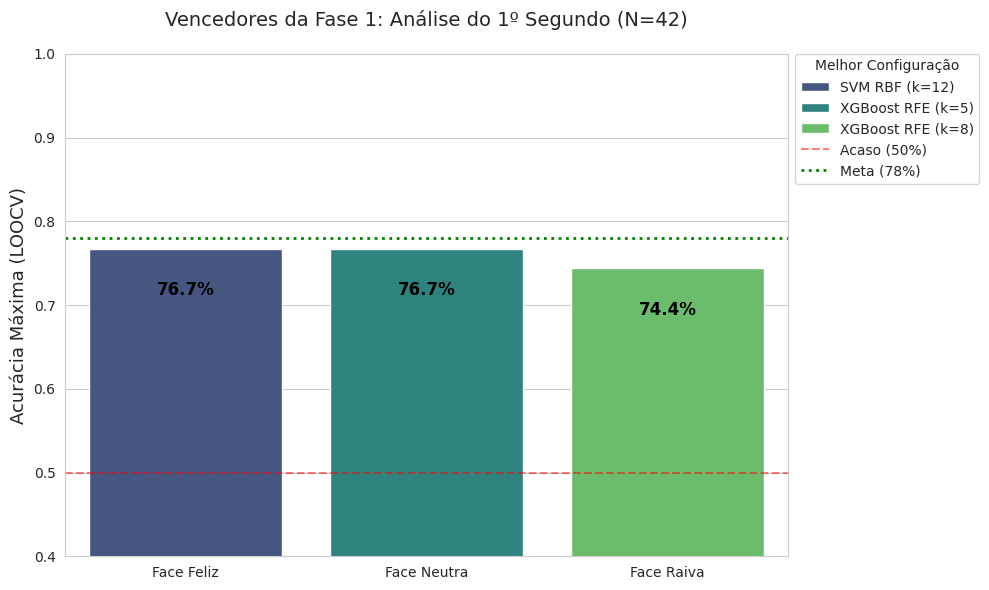

In [2]:
# ==============================================================================
# FASE 1: VARREDURA EXPLORATÓRIA (OTIMIZAÇÃO DE PIPELINE SEM DATA LEAKAGE)
# BASE: 1 SEGUNDO DE PROCESSAMENTO | VALIDAÇÃO: LOOCV | SEMENTE: 97
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar a Nova Base de Dados (Corte de 1 Segundo)
caminho_csv = '../reports/tabela_features_eeg_1segundo.csv'
try:
    df = pd.read_csv(caminho_csv)
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Erro: Arquivo {caminho_csv} não encontrado.")

sns.set_style("whitegrid")
SEED = 97
cv_strategy = LeaveOneOut()

mapeamento_condicoes = {
    'Face Feliz': ['FF', 'F'],
    'Face Neutra': ['FN', 'N'],
    'Face Raiva': ['FR', 'R']
}

print("="*80)
print("🚀 INICIANDO VARREDURA EXPLORATÓRIA (BUSCA DO MODELO > 78%)")
print("="*80)

resultados = []

# Definição do catálogo de modelos e cortes de features a serem testados
configuracoes = [
    # SVM Linear testando cortes estatísticos
    ('SVM Linear (k=5)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=5)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    ('SVM Linear (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    ('SVM Linear (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    
    # SVM RBF (Não-Linear)
    ('SVM RBF (k=5)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=5)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    ('SVM RBF (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    ('SVM RBF (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    
    # Random Forest (Árvores)
    ('Random Forest (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))])),
    ('Random Forest (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))])),
    ('Random Forest (Todas)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced', random_state=SEED))])),
]

# Adicionando os pipelines do XGBoost dinamicamente (precisa de um base_estimator)
for k in [5, 8, 12]:
    xgb_base = XGBClassifier(n_estimators=50, max_depth=2, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    xgb_final = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    pipe = Pipeline([
        ('i', SimpleImputer()),
        ('s', StandardScaler()),
        ('rfe', RFE(estimator=xgb_base, n_features_to_select=k, step=1)),
        ('clf', xgb_final)
    ])
    configuracoes.append((f'XGBoost RFE (k={k})', pipe))

for nome_condicao, lista_triggers in mapeamento_condicoes.items():
    print(f"\n⏳ Varreria em {nome_condicao} (Testando 12 configurações)...")
    
    df_f = df[df['Condicao'].isin(lista_triggers)].copy()
    if df_f.empty: continue
        
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values
    X = df_f.drop(columns=['Condicao', 'Tipo', 'Grupo', 'ID'])
    X = X.dropna(axis=1, how='all')

    for nome_modelo, pipeline in configuracoes:
        acc = cross_val_score(pipeline, X, y, cv=cv_strategy).mean()
        resultados.append({'Condicao': nome_condicao, 'Modelo': nome_modelo, 'Acuracia': acc})

# Compilando Resultados
df_res = pd.DataFrame(resultados)

print("\n" + "="*80)
print("🏆 TOP 3 MELHORES MODELOS POR CONDIÇÃO:")
print("="*80)

for cond in df_res['Condicao'].unique():
    top3 = df_res[df_res['Condicao'] == cond].sort_values(by='Acuracia', ascending=False).head(3)
    print(f"\n📍 {cond.upper()}:")
    for _, row in top3.iterrows():
        destaque = "🚀 ALVO ATINGIDO!" if row['Acuracia'] >= 0.78 else ""
        print(f"   - {row['Modelo']}: {row['Acuracia']:.2%} {destaque}")

# Gráfico dos Campeões
idx_max = df_res.groupby('Condicao')['Acuracia'].idxmax()
melhores = df_res.loc[idx_max]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Condicao', y='Acuracia', hue='Modelo', data=melhores, palette='viridis', edgecolor='white')

plt.ylim(0.4, 1.0)
plt.ylabel('Acurácia Máxima (LOOCV)', fontsize=13)
plt.xlabel('')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Acaso (50%)')
plt.axhline(0.78, color='green', linestyle=':', linewidth=2, label='Meta (78%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Melhor Configuração')

for p in ax.patches:
    if p.get_height() > 0.1:
        cor_texto = 'white' if p.get_height() >= 0.78 else 'black'
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                   ha = 'center', va = 'center', 
                   fontsize=12, fontweight='bold', color=cor_texto)

plt.title('Vencedores da Fase 1: Análise do 1º Segundo (N=42)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

🚀 INICIANDO VARREDURA EXPLORATÓRIA: ÉPOCA COMPLETA (EM BUSCA DOS >78%)

⏳ Varreria em Face Feliz (Avaliando época completa)...

⏳ Varreria em Face Neutra (Avaliando época completa)...

⏳ Varreria em Face Raiva (Avaliando época completa)...

🏆 TOP 3 MELHORES MODELOS POR CONDIÇÃO:

📍 FACE FELIZ:
   - Random Forest (k=12): 79.07% 🚀 ALVO ATINGIDO!
   - Random Forest (Todas): 74.42% 
   - Random Forest (k=8): 74.42% 

📍 FACE NEUTRA:
   - SVM Linear (k=8): 67.44% 
   - SVM RBF (k=5): 67.44% 
   - SVM RBF (k=12): 67.44% 

📍 FACE RAIVA:
   - Random Forest (k=12): 72.09% 
   - Random Forest (Todas): 65.12% 
   - SVM RBF (k=12): 62.79% 


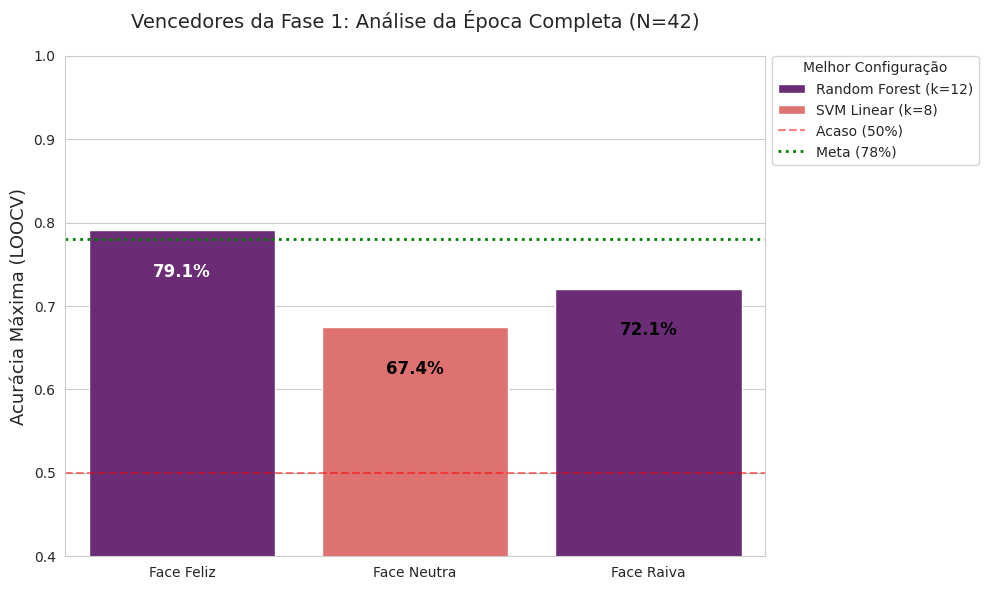

In [3]:
# ==============================================================================
# FASE 1: VARREDURA EXPLORATÓRIA (OTIMIZAÇÃO DE PIPELINE SEM DATA LEAKAGE)
# BASE: ÉPOCA COMPLETA (WELCH + ASSIMETRIA) | VALIDAÇÃO: LOOCV | SEMENTE: 97
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar a Base Completa (Sem o corte de 1 segundo)
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df = pd.read_csv(caminho_csv)
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Erro: Arquivo {caminho_csv} não encontrado.")

sns.set_style("whitegrid")
SEED = 97
cv_strategy = LeaveOneOut()

mapeamento_condicoes = {
    'Face Feliz': ['FF', 'F'],
    'Face Neutra': ['FN', 'N'],
    'Face Raiva': ['FR', 'R']
}

print("="*80)
print("🚀 INICIANDO VARREDURA EXPLORATÓRIA: ÉPOCA COMPLETA (EM BUSCA DOS >78%)")
print("="*80)

resultados = []

configuracoes = [
    # SVM Linear testando cortes estatísticos
    ('SVM Linear (k=5)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=5)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    ('SVM Linear (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    ('SVM Linear (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', SVC(kernel='linear', C=1.0, random_state=SEED))])),
    
    # SVM RBF (Não-Linear)
    ('SVM RBF (k=5)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=5)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    ('SVM RBF (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    ('SVM RBF (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', SVC(kernel='rbf', C=10.0, random_state=SEED))])),
    
    # Random Forest (Árvores)
    ('Random Forest (k=8)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=8)), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))])),
    ('Random Forest (k=12)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('sel', SelectKBest(k=12)), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))])),
    ('Random Forest (Todas)', Pipeline([('i', SimpleImputer()), ('s', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced', random_state=SEED))])),
]

for k in [5, 8, 12]:
    xgb_base = XGBClassifier(n_estimators=50, max_depth=2, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    xgb_final = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    pipe = Pipeline([
        ('i', SimpleImputer()),
        ('s', StandardScaler()),
        ('rfe', RFE(estimator=xgb_base, n_features_to_select=k, step=1)),
        ('clf', xgb_final)
    ])
    configuracoes.append((f'XGBoost RFE (k={k})', pipe))

for nome_condicao, lista_triggers in mapeamento_condicoes.items():
    print(f"\n⏳ Varreria em {nome_condicao} (Avaliando época completa)...")
    
    df_f = df[df['Condicao'].isin(lista_triggers)].copy()
    if df_f.empty: continue
        
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values
    X = df_f.drop(columns=['Condicao', 'Tipo', 'Grupo', 'ID'])
    X = X.dropna(axis=1, how='all')

    for nome_modelo, pipeline in configuracoes:
        acc = cross_val_score(pipeline, X, y, cv=cv_strategy).mean()
        resultados.append({'Condicao': nome_condicao, 'Modelo': nome_modelo, 'Acuracia': acc})

df_res = pd.DataFrame(resultados)

print("\n" + "="*80)
print("🏆 TOP 3 MELHORES MODELOS POR CONDIÇÃO:")
print("="*80)

for cond in df_res['Condicao'].unique():
    top3 = df_res[df_res['Condicao'] == cond].sort_values(by='Acuracia', ascending=False).head(3)
    print(f"\n📍 {cond.upper()}:")
    for _, row in top3.iterrows():
        destaque = "🚀 ALVO ATINGIDO!" if row['Acuracia'] >= 0.78 else ""
        print(f"   - {row['Modelo']}: {row['Acuracia']:.2%} {destaque}")

idx_max = df_res.groupby('Condicao')['Acuracia'].idxmax()
melhores = df_res.loc[idx_max]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Condicao', y='Acuracia', hue='Modelo', data=melhores, palette='magma', edgecolor='white')

plt.ylim(0.4, 1.0)
plt.ylabel('Acurácia Máxima (LOOCV)', fontsize=13)
plt.xlabel('')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Acaso (50%)')
plt.axhline(0.78, color='green', linestyle=':', linewidth=2, label='Meta (78%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Melhor Configuração')

for p in ax.patches:
    if p.get_height() > 0.1:
        cor_texto = 'white' if p.get_height() >= 0.78 else 'black'
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                   ha = 'center', va = 'center', 
                   fontsize=12, fontweight='bold', color=cor_texto)

plt.title('Vencedores da Fase 1: Análise da Época Completa (N=42)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()